# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT

ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

import sys
sys.path.append('../recastCode')
from helper import eventReader

plt.style.use('fivethirtyeight') #Set style
plt.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [2]:
# inputFile = '../pp2ZH/Events/run_02/ctau_1000mm_delphes_events.root'
# ctau = float(inputFile.split('ctau_')[1].split('mm')[0])
inputFile = '../HZcms_1000mm.root'
ctau = 1000.0


In [3]:
methods = ['smearVtx']
Rvals = [None]
nevts = -1
allResults = []
for method,R in itertools.product(methods,Rvals):
    print('Getting results for method = %s and Rmax = %s' %(method,R))
    f = ROOT.TFile(inputFile,'read')
    allResults.append(eventReader(f,nevts,method,R))
    f.Close()

            

Getting results for method = smearVtx and Rmax = None


/home/lessa/higgsEJs/plotting/../recastCode/helper.py:168: RuntimeWarning: divide by zero encountered in log10
  ltheta = np.log10(theta)


SegmentationViolation: void TFile::Close(Option_t* option = "") =>
    SegmentationViolation: segfault in C++; program state was reset

 *** Break *** segmentation violation



There was a crash.
This is the entire stack trace of all threads:

Thread 19 (Thread 0x7c0dcd6006c0 (LWP 133891) "ZMQbg/Reaper"):
#0  0x00007c0dd072a042 in epoll_wait (epfd=5, events=0x7c0dcd5ff1c0, maxevents=256, timeout=-1) at ../sysdeps/unix/sysv/linux/epoll_wait.c:30
#1  0x00007c0dcfb019ed in ?? () from /home/lessa/.local/lib/python3.12/site-packages/zmq/backend/cython/../../../pyzmq.libs/libzmq-5dd2f677.so.5.2.5
#2  0x00007c0dcfb22e77 in ?? () from /home/lessa/.local/lib/python3.12/site-packages/zmq/backend/cython/../../../pyzmq.libs/libzmq-5dd2f677.so.5.2.5
#3  0x00007c0dcfb4ca2a in ?? () from /home/lessa/.local/lib/python3.12/site-packages/zmq/backend/cython/../../../pyzmq.libs/libzmq-5dd2f677.so.5.2.5
#4  0x00007c0dd069ca94 in start_thread (arg=<optimized out>) at ./nptl/pthread_create.c:447
#5  0x00007c0dd0729c3c in clone3 () at ../sysdeps/unix/sysv/linux/x86_64/clone3.S:78

Thread 18 (Thread 0x7c0dccc006c0 (LWP 133892) "ZMQbg/IO/0"):
#

### Plot Distributions

In [4]:
cmsIP2D = np.genfromtxt('../CMS_data/HEPData-ins1954276-v1-Figure_002-a.csv',skip_footer=0,skip_header=148,delimiter=',')
bins = cmsIP2D[:-1,0]-np.diff(cmsIP2D[:,0])/2

In [5]:
title = r'$c\tau_s = %1.0f$ mm' %(ctau)
colors = sns.color_palette('Paired')

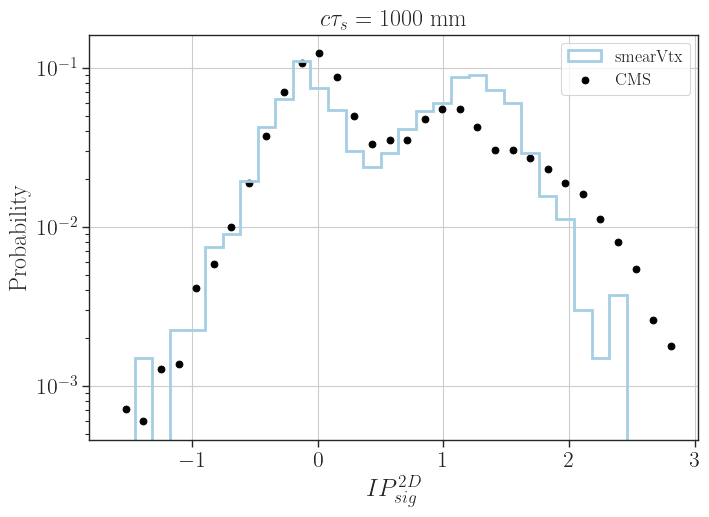

In [6]:
fig = plt.figure(figsize=(7,5))
for i,resDict in enumerate(allResults):
    IP2D = resDict['IP2D']
    label = '%s' %(resDict['method'])
    if resDict['Rmax'] is not None:
        label += r' ($R < %1.0f$ mm)' %resDict['Rmax']
    h1,_,_ = plt.hist(IP2D,histtype='step',linewidth=2,bins=bins,density=False,
                      weights=[1.0/len(IP2D)]*len(IP2D),label=label,color=colors[i])
plt.scatter(cmsIP2D[:,0],cmsIP2D[:,1],label='CMS',color='black')
np.savetxt('./ip2d_1mm.csv',list(zip(bins,h1)),header='bin,bin_content',delimiter=',',fmt='%1.4e')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.ylim(1e-2,10)
# plt.xlim(-1.5,3.0)
plt.grid()
plt.xlabel(r'$IP_{sig}^{2D}$',fontsize=18)
plt.ylabel('Probability')
plt.title(title)

# plt.tight_layout()
plt.savefig('IP2D_1000mm.png')
plt.show()

## Check Event

In [3]:
ievt = 61
np.random.seed(0)
method = 'smearVtx'
Rmax = None
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
tree.GetEntry(ievt)   



jets = tree.Jet
jetsG = tree.GenJet
jetsF = tree.FastJet
jetsE = tree.JES
print('Final jets:')
for ij,j in enumerate(jets):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
print('\nGen jets:')
for ij,j in enumerate(jetsG):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
print('\nFast jets:')
for ij,j in enumerate(jetsF):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
print('\nSmeared jets:')
for ij,j in enumerate(jetsE):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))


# # jets = tree.Jet
# jets = tree.GenJet
# tracks = tree.Track    
# from helper import getJetTracks,getD0,getSigmaD0,getAlpha,getIP2D 
# d0 = []
# sigmaD0 = []
# good_jets = []
# print('----- Event %i ------' %ievt)
# print('%i jets' %len(jets))
# for ij,j in enumerate(jets):
#     print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
#     if j.PT < 35.0:
#         continue
#     if abs(j.Eta) > 2.4:
#         continue
#     good_jets.append(j)
#     jet_tracks = getJetTracks(j,tracks)
#     print('%i tracks matched' %len(jet_tracks))
#     if len(jet_tracks) == 0:
#         continue
#     for it,track in enumerate(jet_tracks):
#         print(' track %i: PT = %1.3f, ID = %i, D0 (true) = %1.2e mm' %(it+1,track.PT,track.PID, track.D0))
#         tD0 = getD0(track,smear=True,method=method)
#         tSD0 = getSigmaD0(track,method=method)
#         print('      after smearing: D0 = %1.2e, sigmaD0 = %1.2e' %(tD0,tSD0) )
#         d0.append(tD0)
#         sigmaD0.append(tSD0)
#     ip2D = getIP2D(jet_tracks,smear=True,method='smearVtx')
#     print('IP2D = %1.3f' %ip2D)

# f.Close()

Final jets:

jet 1: PT = 67.606, jet Eta = 0.063

jet 2: PT = 40.441, jet Eta = 0.430

Gen jets:

jet 1: PT = 88.764, jet Eta = 0.138

jet 2: PT = 85.180, jet Eta = 0.881

jet 3: PT = 67.671, jet Eta = 0.074

jet 4: PT = 49.186, jet Eta = -0.091

Fast jets:

jet 1: PT = 88.035, jet Eta = 0.124

jet 2: PT = 64.576, jet Eta = 0.063

jet 3: PT = 37.584, jet Eta = 0.430

Smeared jets:

jet 1: PT = 91.062, jet Eta = 0.124

jet 2: PT = 67.606, jet Eta = 0.063

jet 3: PT = 40.441, jet Eta = 0.430


In [6]:
electrons = tree.Electron
for ij,j in enumerate(electrons):
    print('\nelectron %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
muons = tree.Muon
for ij,j in enumerate(muons):
    print('\nelectron %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))


electron 1: PT = 87.497, jet Eta = 0.137


In [7]:
particles = tree.Particle
for p in particles:
    if abs(p.PT-87.0) < 5.0 and abs(abs(p.Eta)-0.137) < 0.01:
        print(p.PID)
        break

-11


In [9]:
print(p.PT,p.Eta,p.PID,p.M1,p.M2)

87.27915954589844 0.13675270974636078 -11 2406 -1


In [16]:
mom = particles[p.M1]
print(mom.PT,mom.Eta,mom.PID,mom.D1,mom.D2)

119.6507797241211 0.1306382268667221 23 2409 2410


In [14]:
d2 = particles[mom.D1]
print(d2.PT,d2.Eta,d2.PID)

63.40976333618164 0.05835798382759094 11


In [ ]:
ievt = 61
np.random.seed(0)
method = 'smearVtx'
Rmax = None
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
tree.GetEntry(ievt)   
# jets = tree.Jet
jets = tree.FastJet
tracks = tree.Track    
from helper import getJetTracks,getD0,getSigmaD0,getAlpha,getIP2D 
d0 = []
sigmaD0 = []
good_jets = []
print('----- Event %i ------' %ievt)
print('%i jets' %len(jets))
for ij,j in enumerate(jets):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
    if j.PT < 35.0:
        continue
    if abs(j.Eta) > 2.4:
        continue
    good_jets.append(j)
    jet_tracks = getJetTracks(j,tracks)
    print('%i tracks matched' %len(jet_tracks))
    if len(jet_tracks) == 0:
        continue
    for it,track in enumerate(jet_tracks):
        print(' track %i: PT = %1.3f, ID = %i, D0 (true) = %1.2e mm' %(it+1,track.PT,track.PID, track.D0))
        tD0 = getD0(track,smear=True,method=method)
        tSD0 = getSigmaD0(track,method=method)
        print('      after smearing: D0 = %1.2e, sigmaD0 = %1.2e' %(tD0,tSD0) )
        d0.append(tD0)
        sigmaD0.append(tSD0)
    ip2D = getIP2D(jet_tracks,smear=True,method='smearVtx')
    print('IP2D = %1.3f' %ip2D)

# f.Close()

: 